# MNIST from scratch with numpy

In [1]:
# load changed modules automatically
%reload_ext autoreload
%autoreload 2

In [2]:
# load numpy
import numpy as np

# load dataloaders and required layers
from mnist import dataloader
from mnist.layers import Softmax, Linear, Dropout, ReLU
from mnist.losses import CrossEntropy

# load pyplot for displaying images
from matplotlib import pyplot as plt

# show images inline on notebook
%matplotlib inline

# debugging
import pdb

## Load training data

In [3]:
dl = dataloader.DataLoader()
((x_train, y_train), (x_valid, y_valid), (x_test, (y_test))) = dl.load_data()

In [4]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

## Normalize data

In [5]:
(x_train, y_train), (x_valid, y_valid) = dl.normalize(((x_train, y_train), (x_valid, y_valid)))

## Exploring the data

In [18]:
def show(img):
    plt.imshow(img, cmap="gray")

In [ ]:
valid_images = np.reshape(x_valid, (-1,28,28))

In [ ]:
show(valid_images[0])

## Start building the model

In [6]:
def shuffle(arr1, arr2):
    random_idxs = np.arange(len(arr1))
    np.random.shuffle(random_idxs)
    return arr1[random_idxs], arr2[random_idxs]

In [14]:
# always reproduce the same weights
np.random.seed(1)

class Net(object):
    def __init__(self):
        self.train = True
        self.input_layer = Linear(28*28, 10) # linear layer with bias
        self.softmax = Softmax()
        self.dropout = Dropout(0.1)
        self.cross_entropy = CrossEntropy()
    
    def forward(self, x):
        if self.train:
            x = self.dropout.forward(x)

        x = self.input_layer.forward(x)
        x = self.softmax.forward(x)
        return x
    
    def backward(self, targets):
        grad_loss = net.softmax.backward(targets)
        _, grad_input_layer, grad_bias = net.input_layer.backward(grad_loss)
        return grad_input_layer, grad_bias
    
    def loss(self, y_pred, y):
        return self.cross_entropy.loss(y_pred, y)

net = Net()

In [15]:
debug = False

if debug:
    n_epochs = 1
    batch_size = 3
else:
    n_epochs = 10
    batch_size = 256
    
learning_rate = 1e-1

for epoch in range(n_epochs):
    
    for i in range(0, len(x_train), batch_size):

        inputs = x_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]
        
        inputs, targets = shuffle(inputs, targets)

        if debug:
            print("inputs.shape", inputs.shape)
            print("targets.shape", targets.shape)

        # forward propagation
        y_pred = net.forward(inputs)
        predictions = y_pred.copy()

        if debug:
            print("y_pred.shape:", y_pred.shape)
            print("predictions.shape", predictions.shape)
            
        # calculate cross-entropy loss
        loss = net.loss(predictions, targets)
        
        if debug:
            print(epoch, loss)
        
        # backpropagation
        grad_input_layer, grad_bias = net.backward(targets)
        
        if debug:
            print("grad_input_layer.shape", grad_input_layer.shape)
            print("net.input_layer.weights.shape", net.input_layer.weights.shape)
            print("net.input_layer.bias.shape", net.input_layer.bias.shape)
        
        net.input_layer.weights -= learning_rate * grad_input_layer
        net.input_layer.bias -= learning_rate * grad_bias
        
        if debug:
            break
        
    # calculate validation loss for some random indices
    net.train = False
    random_idxs = np.random.randint(0, len(x_valid), batch_size)
    y_valid_pred = net.forward(x_valid[random_idxs])
    loss_valid = net.loss(y_valid_pred, y_valid[random_idxs])
    net.train = True
    
    #calculate accuracy and validation accuracy
    accuracy = np.mean(y_pred.argmax(axis=1) == targets)
    valid_accuracy = np.mean(y_valid_pred.argmax(axis=1) == y_valid[random_idxs])
    
    print(epoch, loss, loss_valid, accuracy, valid_accuracy)


0 0.3000072308119785 0.39073117677176367 0.9125 0.87890625
1 0.2876592412435876 0.26661347190416196 0.925 0.921875
2 0.2673505985865531 0.2221052878748185 0.9125 0.9296875
3 0.24457945156017638 0.26941002948725695 0.925 0.9140625
4 0.21023881608801612 0.24110944605246998 0.9125 0.921875
5 0.2604654879336149 0.202457411572795 0.925 0.9375
6 0.21781252505162216 0.26353541941770986 0.925 0.921875
7 0.18740159405502868 0.25993454975499963 0.925 0.92578125
8 0.2367375968294728 0.28525791613123685 0.9375 0.92578125
9 0.20236202025208733 0.25875342289821923 0.925 0.9453125


## Check results

In [16]:
# get some random examples from validation data,
# compare predictions with actual values
valid_preds = net.forward(x_valid)
random_idxs = np.random.randint(0, len(x_valid), 10)
np.argmax(valid_preds, axis=1)[random_idxs], y_valid[random_idxs]

(array([0, 8, 0, 4, 2, 9, 8, 7, 4, 4]), array([0, 8, 0, 4, 2, 9, 0, 7, 4, 4]))

prediction: 8 correct: 8


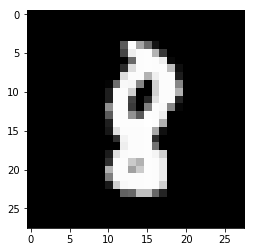

In [23]:
# display a random image from validation data with
# prediction and correct value
valid_images = np.reshape(x_valid, (-1,28,28))
valid_preds = net.forward(x_valid)
random_idx = np.random.randint(0, len(x_valid))
prediction = np.argmax(valid_preds, axis=1)[random_idx]
correct = y_valid[random_idx]
print("prediction:", prediction, "correct:", correct)
show(valid_images[random_idx])